In [2185]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
import warnings
warnings.filterwarnings('ignore')

In [2186]:
%matplotlib inline

In [2187]:
df = pd.read_csv("train.csv")

In [2188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [2189]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2190]:
def sigma(data):
    data_std = data.std()
    valid_data_left = data.mean() - data_std * 3
    valid_data_right = data.mean() + data_std * 3
    data = data.loc[(data > valid_data_left) & (data < valid_data_right)]
    return data

In [2191]:
def quantile(data, left_quantile, right_quantile):
    left_side = data.quantile(q=left_quantile)
    right_side = data.quantile(q=right_quantile)
    data = data.loc[(data > left_side) & (data < right_side)]
    return data

In [2192]:
def statistics(data, left, right):
    return f"минимальное значение: {data.min()},\
    максимальное значение: {data.max()},\
    среднее: {data.mean()},\
    медиана: {data.median()},\
    левый квантиль: {data.quantile(q=left)},\
    правый квантиль: {data.quantile(q=right)}"

In [2193]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


## EDA

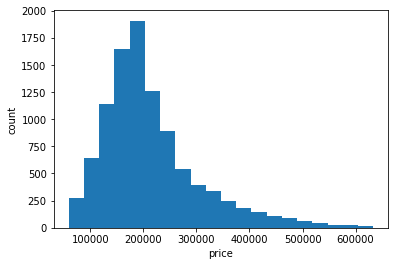

In [2194]:
plt.hist(df["Price"],bins=20, density=False)
plt.ylabel("count")
plt.xlabel("price")
plt.show()

In [2195]:
df_num_features = df.select_dtypes(include=["int8","int16", "int32","float32"])
df_num_features.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>],
       [<AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>],
       [<AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>],
       [<AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

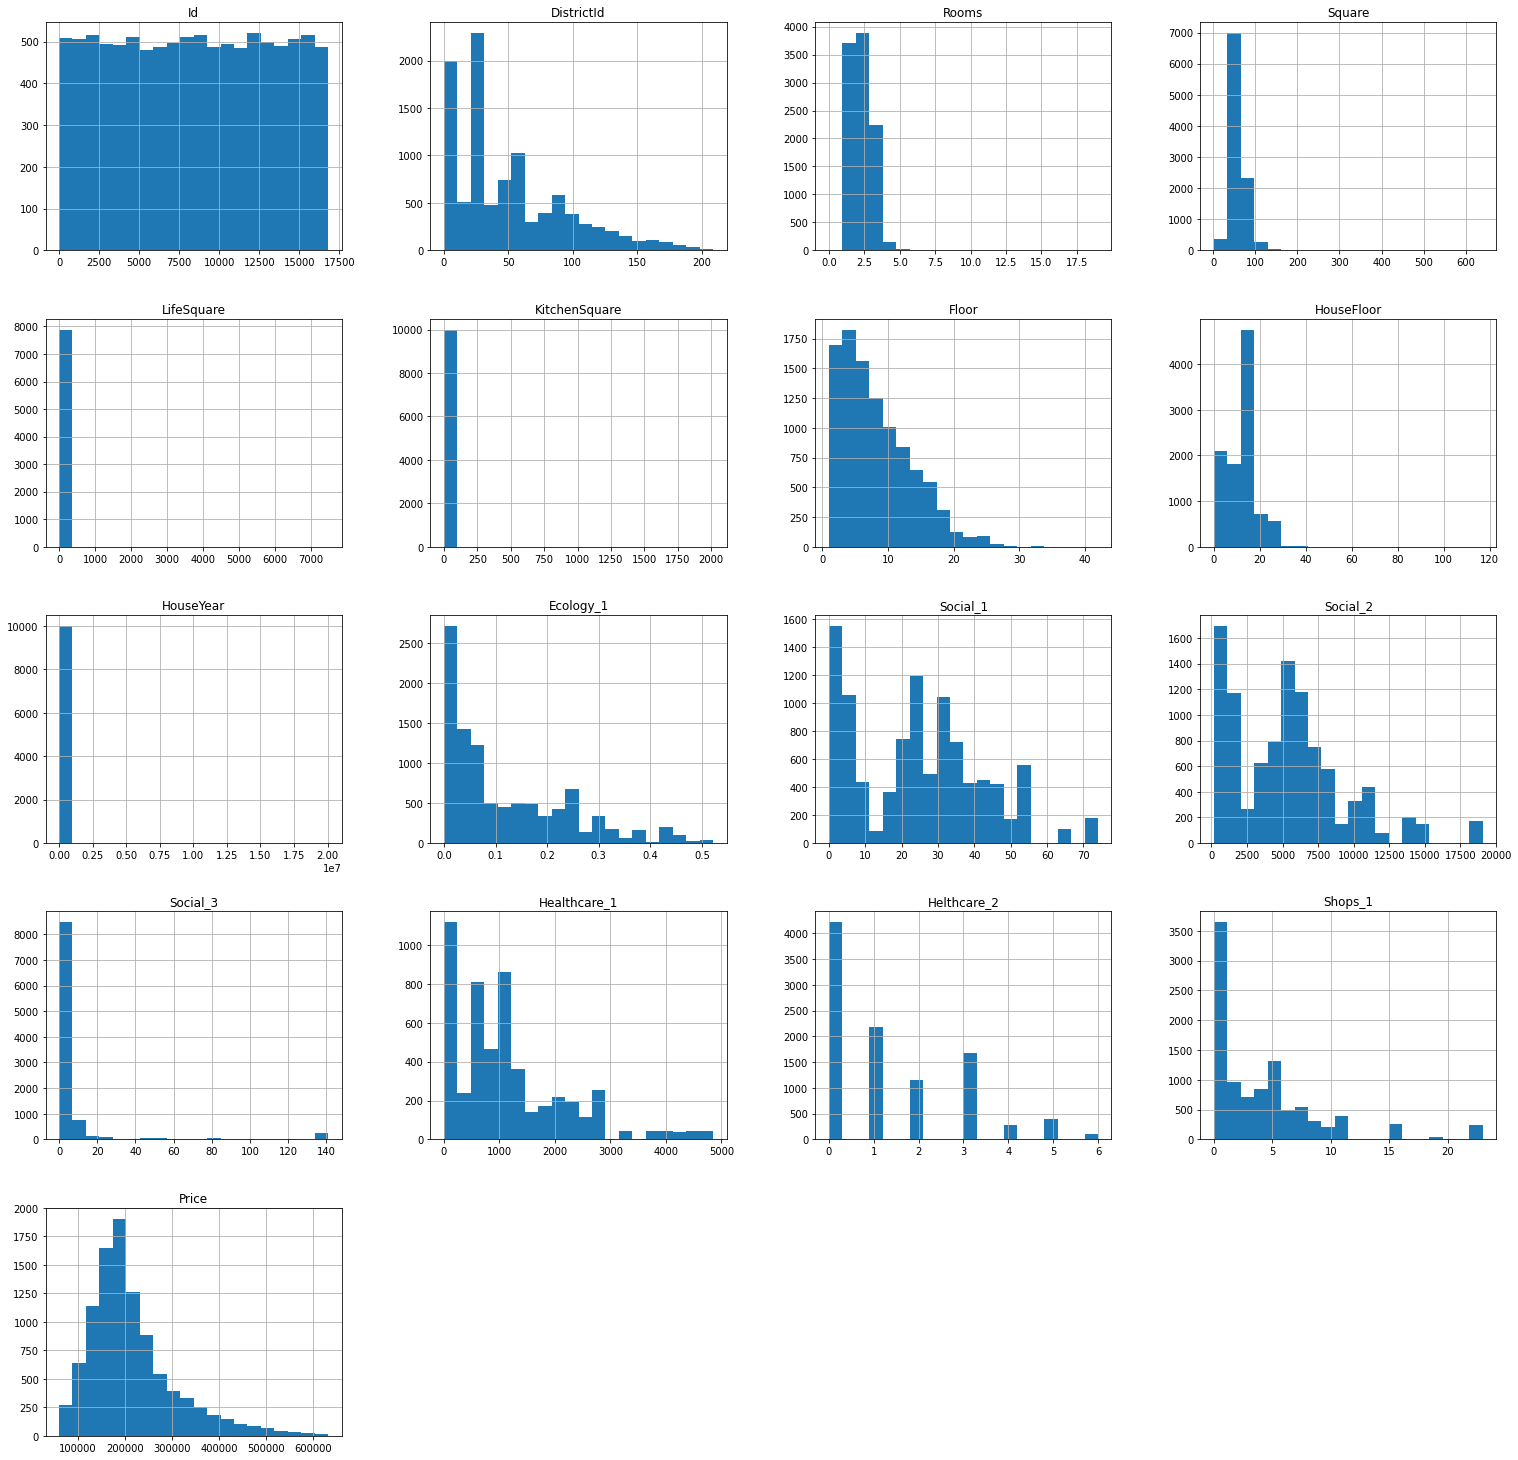

In [2196]:
df_num_features.hist(figsize=(26, 26),bins=20, density=False)

In [2197]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## Заполнение пропущенных значений

In [2198]:
statistics(df["Healthcare_1"], 0.2, 0.98)

'минимальное значение: 0.0,    максимальное значение: 4849.0,    среднее: 1142.9044189453125,    медиана: 900.0,    левый квантиль: 240.0,    правый квантиль: 4129.0'

In [2199]:
statistics(df["LifeSquare"], 0.2, 0.98)

'минимальное значение: 0.37061941623687744,    максимальное значение: 7480.59228515625,    среднее: 37.19964599609375,    медиана: 32.7812614440918,    левый квантиль: 21.757953643798828,    правый квантиль: 83.40705871582031'

In [2200]:
df["LifeSquare_nan"] = 0
df.loc[df["LifeSquare"].isna(), "LifeSquare_nan"] = 1

In [2201]:
df["LifeSquare_nan"].value_counts()

0    7887
1    2113
Name: LifeSquare_nan, dtype: int64

In [2202]:
df["LifeSquare"] = df["LifeSquare"].fillna(df["LifeSquare"].median())

In [2203]:
df["LifeSquare"].isna().sum()

0

In [2204]:
df.drop(columns=["Healthcare_1"], axis=1, inplace=True)

In [2205]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'LifeSquare_nan'],
      dtype='object')

In [2206]:
df.drop(columns=["Id"], axis=1, inplace=True)

In [2207]:
df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Price', 'LifeSquare_nan'],
      dtype='object')

## Замена неадекватных значений


## Площадь и жилая площадь

In [2208]:
statistics(df["Square"], 0.020, 0.995)

'минимальное значение: 1.1368588209152222,    максимальное значение: 641.065185546875,    среднее: 56.31577682495117,    медиана: 52.513309478759766,    левый квантиль: 31.53776779174805,    правый квантиль: 132.82090370178219'

In [2209]:
small_square = df["Square"] < 20
small_square.sum()

21

In [2210]:
df.loc[df["Square"] < 20, "Square"]= df["Square"].quantile(0.025)


In [2211]:
df[df["Square"] < 20]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


In [2212]:
df["Square"].quantile(q=0.995)

132.82090370178219

In [2213]:
df.loc[df["Square"] > df["Square"].quantile(q=0.995), "Square" ] = round(df["Square"].quantile(q=0.995))

In [2214]:
df[df["Square"] > 133]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


In [2215]:
statistics(df["LifeSquare"], 0.025, 0.98)

'минимальное значение: 0.37061941623687744,    максимальное значение: 7480.59228515625,    среднее: 36.26603698730469,    медиана: 32.7812614440918,    левый квантиль: 15.14612386226654,    правый квантиль: 80.5779316711426'

In [2216]:
small_lifesquare = df["LifeSquare"] < 10
small_lifesquare.sum()

205

In [2217]:
df.loc[df["LifeSquare"] < 10, "LifeSquare"] = df["LifeSquare"].quantile(q=0.025)

In [2218]:
df[df["LifeSquare"] < 10]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


In [2219]:
df.loc[df["LifeSquare"] > df["Square"], "LifeSquare"] = df["LifeSquare"].quantile(q=0.025)

In [2220]:
df[df["LifeSquare"] > df["Square"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


In [2221]:
life = quantile(df["LifeSquare"], 0.025, 0.995)

In [2222]:
life.max(), life.size

(87.832825, 9700)

In [2223]:
df[df["LifeSquare"] > 91]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
403,13,5.0,133.000000,100.985504,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,5,15,B,622888.812500,0
443,27,3.0,120.771217,118.048981,1.0,8,1.0,1977,0.072158,B,B,2,629,1,0,0,A,275644.718750,0
452,27,2.0,92.400009,92.069237,10.0,2,5.0,1977,0.075424,B,B,11,3097,0,0,0,B,116942.671875,0
761,30,1.0,117.370743,102.187202,6.0,14,40.0,2011,0.000078,B,B,22,6398,141,3,23,B,521829.562500,0
838,27,3.0,103.683548,102.886559,1.0,9,1.0,2018,0.072158,B,B,2,629,1,0,0,A,227866.343750,0
1459,34,5.0,121.577423,114.913841,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,1,11,B,455446.406250,0
1487,58,3.0,95.970757,93.323296,1.0,4,3.0,1977,0.437885,B,B,23,5735,3,0,5,B,222643.171875,0
1606,56,3.0,133.000000,107.376167,19.0,7,3.0,2007,0.000000,B,B,23,5067,4,2,6,B,338644.062500,0
2066,183,4.0,133.000000,98.187485,23.0,6,7.0,1912,0.037316,B,B,32,6748,93,4,10,B,284884.968750,0
2436,17,2.0,102.683647,101.525116,1.0,20,1.0,1977,0.093443,B,B,23,4635,5,2,4,B,573999.437500,0


In [2224]:
df.loc[df["LifeSquare"] > 90, "LifeSquare"] = df["LifeSquare"].quantile(q=0.995)
df.loc[df["LifeSquare"] > 90, "Square"] = df["Square"].quantile(q=0.995)
df[df["LifeSquare"] > 91]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


## Количество комнат

In [2225]:
df[df["Rooms"]==0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
2194,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,3,9,B,158998.109375,0
3780,27,0.0,41.790882,32.781261,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,0,1,B,98129.976562,1
5894,28,0.0,49.483501,32.781261,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1,0,B,217009.343750,1
6401,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,0,1,B,219281.921875,0
7644,27,0.0,133.000000,15.146286,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,0,1,B,302211.250000,0
7929,6,0.0,81.491447,32.781261,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,0,0,B,212864.796875,1
9767,27,0.0,133.000000,15.146286,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,0,0,B,268394.750000,0
9869,27,0.0,32.105183,15.146124,0.0,1,0.0,1977,0.017647,B,B,2,469,0,0,0,B,126596.945312,0


In [2226]:
df["Rooms"].mode()

0    2.0
dtype: float32

In [2227]:
df.loc[df["Rooms"]==0, "Rooms"] = 2

In [2228]:
df[df["Rooms"] >= 6]


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
2004,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,5,15,B,317265.312500,0
2728,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,2,4,B,172329.265625,0
6088,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,0,1,B,78364.617188,0
8794,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,3,8,B,229661.968750,0


In [2229]:
df.loc[df["Rooms"] >= 6, "Rooms"] = 2

## Кухня

In [2230]:
statistics(df["KitchenSquare"], 0.2, 0.995)

'минимальное значение: 0.0,    максимальное значение: 2014.0,    среднее: 6.2733001708984375,    медиана: 6.0,    левый квантиль: 1.0,    правый квантиль: 20.0'

In [2231]:
df[(df["KitchenSquare"] != 0) & (df["KitchenSquare"] <= 3)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
3,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,B,B,1,264,0,0,1,B,168106.000000,1
8,1,1.0,46.887894,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,0,1,B,160400.406250,0
9,6,3.0,79.867477,75.085129,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,194756.031250,0
18,1,1.0,47.582481,32.781261,1.0,16,16.0,1977,0.007122,B,B,1,264,0,0,1,B,128803.593750,1
19,45,1.0,42.367290,40.012527,1.0,16,14.0,2015,0.195781,B,B,23,5212,6,3,2,B,250466.984375,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9979,6,1.0,40.043236,15.146286,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,134888.078125,0
9981,62,2.0,73.092690,32.781261,1.0,4,16.0,2017,0.072158,B,B,2,629,1,0,0,A,159077.203125,1
9982,27,1.0,36.112392,15.146124,1.0,9,16.0,1977,0.211401,B,B,9,1892,0,0,1,B,94881.695312,0
9983,1,2.0,63.324024,32.781261,1.0,4,17.0,1977,0.007122,B,B,1,264,0,0,1,B,183809.328125,1


In [2232]:
df.loc[(df["KitchenSquare"] != 0) & (df["KitchenSquare"] <= 3),  "KitchenSquare"] = df["KitchenSquare"].median()

In [2233]:
df[df["KitchenSquare"] > 20]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
277,79,1.0,96.838013,49.140961,22.0,19,24.0,2016,0.050756,B,B,24,5469,1,0,1,B,348962.875000,0
286,27,3.0,123.430069,15.146286,123.0,5,10.0,2015,0.017647,B,B,2,469,0,0,0,B,234194.843750,0
456,62,1.0,46.013187,43.417042,43.0,4,17.0,2019,0.072158,B,B,2,629,1,0,0,A,113909.101562,0
511,62,5.0,124.933289,81.122368,30.0,5,3.0,2017,0.072158,B,B,2,629,1,0,0,A,271919.875000,0
682,52,2.0,64.859245,32.781261,62.0,15,17.0,1977,0.371149,B,B,34,7065,1,2,5,B,185993.468750,1
755,10,1.0,35.813564,19.953993,35.0,6,14.0,1971,0.282798,B,B,33,8667,2,0,6,B,164306.312500,0
1614,58,3.0,133.000000,15.146286,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,0,5,B,169528.890625,0
1728,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,1,9,B,370148.625000,0
1776,27,4.0,133.000000,15.146286,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,1,4,B,528560.500000,0
1906,86,5.0,133.000000,15.146286,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,3,7,B,455264.875000,0


In [2234]:
df.loc[df["KitchenSquare"] > 20, "KitchenSquare"]= df["KitchenSquare"].quantile(q=0.75)

In [2235]:
df[df["KitchenSquare"] > 20]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


## Несоответствие общей площади

In [2236]:
df[df["Square"] < df["KitchenSquare"] + df["LifeSquare"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
8,1,1.0,46.887894,44.628132,6.0,12,20.0,1977,0.007122,B,B,1,264,0,0,1,B,160400.406250,0
9,6,3.0,79.867477,75.085129,6.0,3,17.0,2014,0.243205,B,B,5,1564,0,0,0,B,194756.031250,0
19,45,1.0,42.367290,40.012527,6.0,16,14.0,2015,0.195781,B,B,23,5212,6,3,2,B,250466.984375,0
34,27,2.0,58.783661,55.441257,11.0,13,12.0,1977,0.011654,B,B,4,915,0,0,0,B,138396.984375,0
37,9,1.0,78.936165,76.746651,6.0,8,7.0,1977,0.161532,B,B,25,5648,1,2,4,B,226206.968750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9917,27,1.0,41.674873,40.989613,9.0,12,19.0,2017,0.211401,B,B,9,1892,0,0,1,B,99353.476562,0
9927,182,2.0,67.838860,65.200027,9.0,7,8.0,1918,0.015017,B,B,17,3079,59,0,8,B,443270.812500,0
9939,45,2.0,57.788677,55.033787,6.0,4,10.0,1977,0.195781,B,B,23,5212,6,3,2,B,312993.343750,0
9942,58,1.0,41.806065,40.202217,6.0,1,4.0,2015,0.437885,B,B,23,5735,3,0,5,B,94194.140625,0


In [2237]:
less_square = df[df["Square"] < df["KitchenSquare"] + df["LifeSquare"]]
difference = np.abs(less_square["Square"] -(less_square["KitchenSquare"] + less_square["LifeSquare"]))
df.loc[df["Square"] < df["KitchenSquare"] + df["LifeSquare"], "Square"] += difference

In [2238]:
df[df["Square"] < df["KitchenSquare"] + df["LifeSquare"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


In [2239]:
df[df["KitchenSquare"] > df["LifeSquare"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
2180,23,1.0,55.282146,11.168019,20.0,4,3.0,2013,0.014073,B,B,2,475,0,0,0,B,157140.843750,0
3976,27,1.0,32.712360,11.047605,13.0,8,25.0,2016,0.072158,B,B,2,629,1,0,0,A,94433.039062,0
5404,62,1.0,41.735073,12.423181,14.0,3,15.0,2010,0.072158,B,B,2,629,1,0,0,A,80331.109375,0
5631,113,3.0,125.287186,15.146286,19.0,26,24.0,2017,0.050756,B,B,24,5469,1,0,1,B,522197.031250,0
6794,161,1.0,50.808926,15.920343,20.0,8,9.0,1910,0.014423,B,B,19,3806,4,0,3,B,287954.718750,0
9746,27,2.0,43.956043,10.523869,19.0,15,17.0,2006,0.075424,B,B,11,3097,0,0,0,B,143688.078125,0


In [2240]:
df.loc[df["KitchenSquare"] > df["LifeSquare"], "KitchenSquare"] = df["KitchenSquare"].median()

In [2241]:
df[df["KitchenSquare"] > df["Square"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


## Неадекватная этажность дома или квартиры

In [2242]:
df[df["Floor"] > df["HouseFloor"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
17,8,2.0,49.396000,28.299601,5.0,6,5.0,1962,0.458174,B,A,26,4439,1,1,5,B,186971.921875,0
19,45,1.0,46.012527,40.012527,6.0,16,14.0,2015,0.195781,B,B,23,5212,6,3,2,B,250466.984375,0
21,20,3.0,75.611061,47.494621,8.0,11,9.0,1976,0.019509,B,B,37,7687,11,5,5,B,366916.250000,0
24,27,1.0,44.203945,32.781261,0.0,2,0.0,1977,0.072158,B,B,2,629,1,0,0,A,135466.562500,1
25,6,2.0,65.409966,32.781261,6.0,18,1.0,1977,0.243205,B,B,5,1564,0,0,0,B,191205.265625,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,48,3.0,96.056786,15.146286,6.0,15,1.0,2017,0.041125,B,B,46,9515,5,1,10,B,524365.562500,0
9968,1,3.0,86.487549,32.781261,6.0,18,17.0,1977,0.007122,B,B,1,264,0,0,1,B,248248.937500,1
9970,6,1.0,41.310417,19.117077,9.0,18,17.0,1977,0.243205,B,B,5,1564,0,0,0,B,114878.828125,0
9975,6,2.0,52.573132,32.781261,6.0,18,17.0,1977,0.243205,B,B,5,1564,0,0,0,B,154366.031250,1


In [2243]:
statistics(df["Floor"], 0.2, 0.98)

'минимальное значение: 1,    максимальное значение: 42,    среднее: 8.5267,    медиана: 7.0,    левый квантиль: 4.0,    правый квантиль: 21.0'

In [2244]:
statistics(df["HouseFloor"], 0.2, 0.98)

'минимальное значение: 0.0,    максимальное значение: 117.0,    среднее: 12.609399795532227,    медиана: 13.0,    левый квантиль: 5.0,    правый квантиль: 25.0'

In [2245]:
df[df["HouseFloor"] == 0]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
24,27,1.0,44.203945,32.781261,0.0,2,0.0,1977,0.072158,B,B,2,629,1,0,0,A,135466.562500,1
152,53,2.0,56.023342,32.781261,0.0,14,0.0,1977,0.049637,B,B,34,7759,0,1,3,B,247074.562500,1
159,74,1.0,46.449711,32.781261,0.0,6,0.0,1977,0.075779,B,B,6,1437,3,0,2,B,168705.453125,1
186,62,1.0,44.954880,32.781261,0.0,8,0.0,1977,0.072158,B,B,2,629,1,0,0,A,133773.296875,1
229,45,3.0,81.094925,32.781261,0.0,15,0.0,1977,0.195781,B,B,23,5212,6,3,2,B,442472.468750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,27,1.0,42.936726,32.781261,0.0,2,0.0,1977,0.011654,B,B,4,915,0,0,0,B,129674.843750,1
9931,1,1.0,47.402412,32.781261,0.0,14,0.0,1977,0.007122,B,B,1,264,0,0,1,B,174740.296875,1
9940,6,1.0,41.224117,32.781261,0.0,8,0.0,1977,0.243205,B,B,5,1564,0,0,0,B,125612.640625,1
9950,48,3.0,98.994911,32.781261,0.0,3,0.0,1977,0.041125,B,B,46,9515,5,1,10,B,418817.000000,1


In [2246]:
df.loc[df["Floor"] > df["HouseFloor"], "HouseFloor"] = df["Floor"]

In [2247]:
df[df["Floor"] > df["HouseFloor"]]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


## Год постройки

In [2248]:
statistics(df["HouseYear"], 0.2, 0.98)

'минимальное значение: 1910,    максимальное значение: 20052011,    среднее: 3990.1663,    медиана: 1977.0,    левый квантиль: 1971.0,    правый квантиль: 2018.0'

In [2249]:
year = datetime.now().year

In [2250]:
df[df["HouseYear"] > year]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
8828,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,5,8,B,243028.609375,0
9163,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,3,6,B,254084.531250,0


In [2251]:
df.loc[df["HouseYear"] > year, "HouseYear"]  = year

In [2252]:
df[df["HouseYear"] > year] 

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


In [2253]:
df["HouseYear"].min()

1910

In [2254]:
df["number_of_year"] = 0
df.loc[df["HouseYear"] <= 1940, "number_of_year"] = 1
df.loc[(df["HouseYear"] > 1940) & (df["HouseYear"] <= 1970), 'number_of_year'] = 2
df.loc[(df["HouseYear"] > 1970) & (df["HouseYear"] <= 2000), 'number_of_year'] = 3
df.loc[df["HouseYear"] > 2000, "number_of_year"] = 4

In [2255]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   DistrictId      10000 non-null  int16   
 1   Rooms           10000 non-null  float32 
 2   Square          10000 non-null  float32 
 3   LifeSquare      10000 non-null  float32 
 4   KitchenSquare   10000 non-null  float32 
 5   Floor           10000 non-null  int8    
 6   HouseFloor      10000 non-null  float32 
 7   HouseYear       10000 non-null  int32   
 8   Ecology_1       10000 non-null  float32 
 9   Ecology_2       10000 non-null  category
 10  Ecology_3       10000 non-null  category
 11  Social_1        10000 non-null  int8    
 12  Social_2        10000 non-null  int16   
 13  Social_3        10000 non-null  int16   
 14  Helthcare_2     10000 non-null  int8    
 15  Shops_1         10000 non-null  int8    
 16  Shops_2         10000 non-null  category
 17  Price        

## Категориальные переменные

In [2256]:
dammy_types = df.select_dtypes(include=["category"])
dammies_df = pd.get_dummies(dammy_types)
df = pd.concat([df, dammies_df], axis=1)

In [2257]:
df = df.drop(dammy_types, axis=1)

In [2258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DistrictId      10000 non-null  int16  
 1   Rooms           10000 non-null  float32
 2   Square          10000 non-null  float32
 3   LifeSquare      10000 non-null  float32
 4   KitchenSquare   10000 non-null  float32
 5   Floor           10000 non-null  int8   
 6   HouseFloor      10000 non-null  float32
 7   HouseYear       10000 non-null  int32  
 8   Ecology_1       10000 non-null  float32
 9   Social_1        10000 non-null  int8   
 10  Social_2        10000 non-null  int16  
 11  Social_3        10000 non-null  int16  
 12  Helthcare_2     10000 non-null  int8   
 13  Shops_1         10000 non-null  int8   
 14  Price           10000 non-null  float32
 15  LifeSquare_nan  10000 non-null  int64  
 16  number_of_year  10000 non-null  int64  
 17  Ecology_2_A     10000 non-null  

In [2259]:
df["DistrictId"].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

## Размер района в процентах

In [2260]:
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Price,LifeSquare_nan,number_of_year,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,DistrictSize
0,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,11,...,305018.875000,1,4,0,1,0,1,0,1,851
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,...,177734.546875,0,2,0,1,0,1,0,1,78
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,...,282078.718750,0,3,0,1,0,1,0,1,652
3,1,1.0,40.409908,32.781261,6.0,10,22.0,1977,0.007122,1,...,168106.000000,1,3,0,1,0,1,0,1,652
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,...,343995.093750,0,3,0,1,0,1,0,1,89


In [2261]:
df["District_size_%"] = (df["DistrictSize"] / df["DistrictSize"].value_counts().sum() ) * 100


## метод главных компонент на признаки

In [2262]:
social = df[["Social_1", "Social_2", "Social_3"]]
shops = df[["Shops_2_A", "Shops_2_B"]]
pca = PCA(n_components=1)
all_social = pca.fit_transform(social)
all_shops = pca.fit_transform(shops)
all_social = pd.DataFrame(all_social, columns=["all_social"])
all_shops = pd.DataFrame(all_shops, columns=["all_shops"])

In [2263]:
df = pd.concat([df, all_social, all_shops], axis=1)
df.drop(columns=["DistrictId","DistrictSize", "Social_1", "Social_2","Social_3", "Shops_2_A", "Shops_2_B"], axis=1, inplace=True)

In [2264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rooms            10000 non-null  float32
 1   Square           10000 non-null  float32
 2   LifeSquare       10000 non-null  float32
 3   KitchenSquare    10000 non-null  float32
 4   Floor            10000 non-null  int8   
 5   HouseFloor       10000 non-null  float32
 6   HouseYear        10000 non-null  int32  
 7   Ecology_1        10000 non-null  float32
 8   Helthcare_2      10000 non-null  int8   
 9   Shops_1          10000 non-null  int8   
 10  Price            10000 non-null  float32
 11  LifeSquare_nan   10000 non-null  int64  
 12  number_of_year   10000 non-null  int64  
 13  Ecology_2_A      10000 non-null  uint8  
 14  Ecology_2_B      10000 non-null  uint8  
 15  Ecology_3_A      10000 non-null  uint8  
 16  Ecology_3_B      10000 non-null  uint8  
 17  District_size

In [2265]:
statistics(df["Ecology_1"], 0.2, 0.98)

'минимальное значение: 0.0,    максимальное значение: 0.521867036819458,    среднее: 0.11885751783847809,    медиана: 0.07542368024587631,    левый квантиль: 0.007720281835645437,    правый квантиль: 0.43788525462150574'

In [2305]:
statistics(df["Price"], 0.1, 0.99)

'минимальное значение: 59174.77734375,    максимальное значение: 633233.4375,    среднее: 214138.859375,    медиана: 192269.65625,    левый квантиль: 118846.15000000001,    правый квантиль: 526300.6418750001'

In [2380]:
df["Square"].max(), df["LifeSquare"].max()

(133.0, 89.78767)

In [2381]:
df.to_csv("train_data.csv", index=False, encoding='utf-8')

In [2382]:
class DataPreprocessing:
    """Параметры"""
    def __init__(self):
        self.median_lifesquare = None
        self.median_kithcensquare = None
        self.kitchen_square_quantile_left = None
        self.kitchen_square_quantile_right = None
        self.lifesquare_quantile_left = None
        self.lifesquare_quantile_right = None
        self.square_quantile_left = None
        self.square_quantile_right = None
        self.rooms_mode = None
        
        
    def fit(self, df):
        self.median_lifesquare = df["LifeSquare"].median()
        self.median_kithcensquare = df["KitchenSquare"].median()
        self.kitchen_square_quantile_left = df["KitchenSquare"].quantile(q=0.02)
        self.kitchen_square_quantile_right = df["KitchenSquare"].quantile(q=0.75)
        self.lifesquare_quantile_left = df["LifeSquare"].quantile(q=0.025)
        self.lifesquare_quantile_right = df["LifeSquare"].quantile(q=0.995)
        self.square_quantile_left = df["Square"].quantile(q=0.025)
        self.square_quantile_right = df["Square"].quantile(q=0.995)
        self.rooms_mode = df["Rooms"].mode()
        
        
    def transform(self, df):
        # пропуски
        df["LifeSquare_nan"] = 0
        df.loc[df["LifeSquare"].isna(), "LifeSquare_nan"] = 1
        df["LifeSquare"] = df["LifeSquare"].fillna(self.median_lifesquare)
        # площадь
        df.loc[df["Square"] < 20, "Square"] = self.square_quantile_left
        df.loc[df["Square"] > self.square_quantile_right, "Square"] = round(self.square_quantile_right)
        # жилая площадь
        df.loc[df["LifeSquare"] < 10, "LifeSquare"] = self.lifesquare_quantile_left
        df.loc[df["LifeSquare"] > self.lifesquare_quantile_right, "LifeSquare"] = self.lifesquare_quantile_right
        # кухня
        df.loc[(df["KitchenSquare"] != 0) & (df["KitchenSquare"] <= 3),  "KitchenSquare"] = \
        self.median_kithcensquare
        df.loc[df["KitchenSquare"] > 20, "KitchenSquare"] = self.kitchen_square_quantile_right
        # разница площадей
        df.loc[df["LifeSquare"] > df["Square"], "LifeSquare"] = self.lifesquare_quantile_left
        less_square = df[df["Square"] < df["KitchenSquare"] + df["LifeSquare"]]
        difference = np.abs(less_square["Square"] - (less_square["KitchenSquare"] + less_square["LifeSquare"]))
        df.loc[df["Square"] < df["KitchenSquare"] + df["LifeSquare"], "Square"] += difference
        # комнаты
        df.loc[(df["Rooms"] == 0) & (df["Rooms"] >= 6), "Rooms"] = self.rooms_mode
        # год постройки
        year = datetime.now().year
        df.loc[df["HouseYear"] > year, "HouseYear"]  = year
        # этаж
        df.loc[df["Floor"] > df["HouseFloor"], "HouseFloor"] = df["Floor"]
        

In [2383]:
df_2 = pd.read_csv("train.csv")
valid_df = pd.read_csv("test.csv")

In [2384]:
df_2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [2385]:
y = df_2["Price"]
x = df_2.drop(columns=["Price"])
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=42)

In [2386]:
x_train.shape, x_test.shape, y_train.shape

((7500, 19), (2500, 19), (7500,))

In [2387]:
preprocessor = DataPreprocessing()

In [2388]:
preprocessor.fit(x_train)

In [2389]:
preprocessor.transform(x_train)
preprocessor.transform(x_test)
preprocessor.transform(valid_df)

In [2390]:
def dummies(df):
    df = pd.get_dummies(df)
    district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    df["District_size_%"] = (df["DistrictSize"] / df["DistrictSize"].value_counts().sum() ) * 100
    social = df[["Social_1", "Social_2", "Social_3"]]
    shops = df[["Shops_2_A", "Shops_2_B"]]
    ecology_2 = df[["Ecology_2_A", "Ecology_2_B"]]
    ecology_3 = df[["Ecology_3_A", "Ecology_3_B"]]
    pca = PCA(n_components=1)
    ecology_2 = pca.fit_transform(ecology_2)
    ecology_3 = pca.fit_transform(ecology_3)
    all_social = pca.fit_transform(social)
    all_shops = pca.fit_transform(shops)
    all_shops = pd.DataFrame(all_shops, columns=["all_shops"])
    ecology_2 = pd.DataFrame(ecology_2, columns=["ecology_2"])
    ecology_3 = pd.DataFrame(ecology_3, columns=["ecology_3"])
    df = pd.concat([df, all_shops, ecology_2, ecology_3], axis=1)
    df["number_of_year"] = 0
    df.loc[df["HouseYear"] <= 1940, "number_of_year"] = 1
    df.loc[(df["HouseYear"] > 1940) & (df["HouseYear"] <= 1970), 'number_of_year'] = 2
    df.loc[(df["HouseYear"] > 1970) & (df["HouseYear"] <= 2000), 'number_of_year'] = 3
    df.loc[df["HouseYear"] > 2000, "number_of_year"] = 4
    df["unlife_square"] = df["Square"] - df["LifeSquare"]
        
    return df

In [2391]:
def cut_features(df):
    df.drop(columns=["DistrictId", "DistrictSize" ,\
                     "Social_3", "Shops_2_A", "Shops_2_B", "Id", "Healthcare_1", \
                    "Ecology_2_A", "Ecology_2_B", "Ecology_3_A", "Ecology_3_B", "ecology_2", "LifeSquare_nan"],axis=1, inplace=True)
    return df

In [2392]:
x_train = dummies(x_train)
x_test = dummies(x_test)
valid_df = dummies(valid_df)

In [2393]:
x_train = cut_features(x_train)
x_test = cut_features(x_test)
valid_df = cut_features(valid_df)

In [2394]:
x_train.isna().sum().sum()

0

In [2395]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2396]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8, 8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [2397]:
# params = {'max_depth':[10, 15, 20, 30, 40],\
#           'min_samples_leaf':[10, 15, 20, 30, 40],\
#           'n_estimators':[50, 100, 150, 200, 250]}

# grid = GridSearchCV(r_forest, params, scoring='r2', n_jobs=-1)

# grid.fit(x_train, y_train)

# grid.best_params_

In [2398]:
r2_forest = RandomForestRegressor(random_state=42, max_depth=30, n_estimators=150, min_samples_leaf=10)

In [2399]:
r2_forest.fit(x_train, y_train)
y2_predict = r2_forest.predict(x_train)
y2_test_predict = r2_forest.predict(x_test)
valid2_predict = r2_forest.predict(valid_df)

R2:	0.812
RMSE:	39818.643
MSE:	1585524343.053


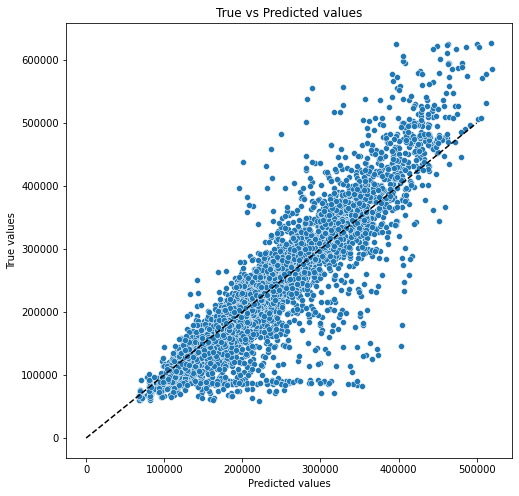

In [2400]:
evaluate_preds(y_train, y2_predict)

R2:	0.699
RMSE:	52455.707
MSE:	2751601230.854


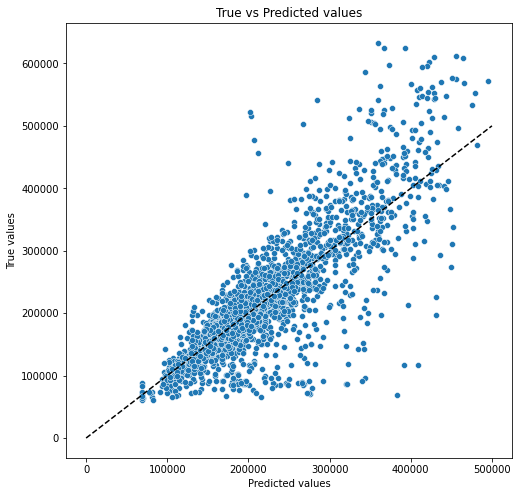

In [2401]:
evaluate_preds(y_test, y2_test_predict)

In [2402]:
submit = pd.read_csv('sample_submission.csv')
submit["Price"] = valid2_predict
submit.head()

,Id,Price
0,4567,159057.043333
1,5925,119822.948054
2,960,142132.071829
3,3848,130983.289469
4,746,197615.663738


In [2403]:
submit.to_csv('submit_2.csv', index=False)

In [2404]:
gradient = GradientBoostingRegressor(random_state=42, max_depth=5, min_samples_leaf=10, n_estimators=200)

In [2405]:
gradient.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=5, min_samples_leaf=10, n_estimators=200,
                          random_state=42)

In [2406]:
y_train_pred = gradient.predict(x_train)
y_test_pred = gradient.predict(x_test)
valid_pred = gradient.predict(valid_df)

R2:	0.88
RMSE:	31860.494
MSE:	1015091082.496


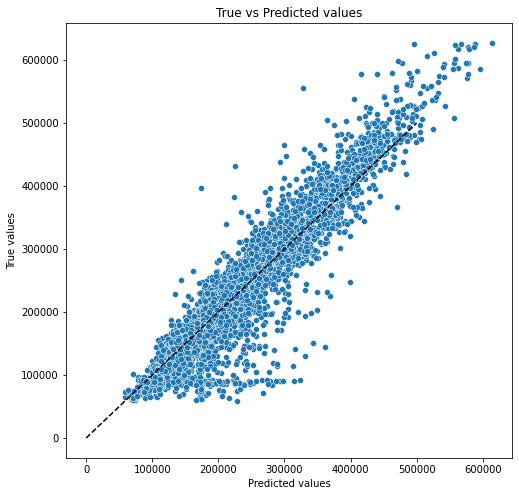

In [2407]:
evaluate_preds(y_train, y_train_pred)

R2:	0.731
RMSE:	49540.266
MSE:	2454237923.826


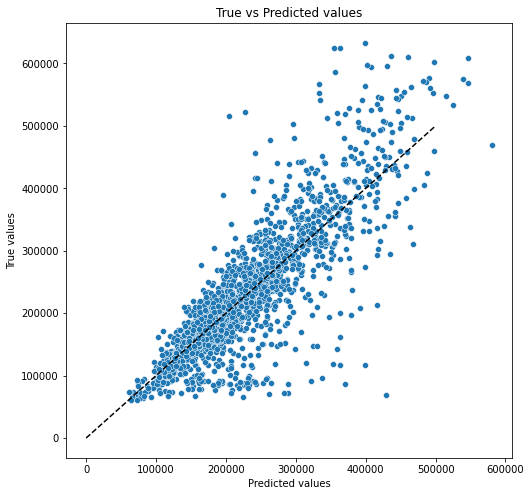

In [2408]:
evaluate_preds(y_test, y_test_pred)

In [2409]:
gradient.feature_importances_

array([0.02604403, 0.43467836, 0.01740683, 0.01602674, 0.01361469,
       0.01990277, 0.03213195, 0.0324612 , 0.02329709, 0.04171427,
       0.01396703, 0.01391802, 0.28811914, 0.00166249, 0.00117576,
       0.00057157, 0.02330806])

In [2410]:
features = pd.DataFrame(zip(x_train.columns,gradient.feature_importances_),columns=['feature_name', 'importance'])

In [2411]:
features.sort_values(by='importance', ascending=False, inplace=True)
features.head(5)

,feature_name,importance
1,Square,0.434678
12,District_size_%,0.288119
9,Social_2,0.041714
7,Ecology_1,0.032461
6,HouseYear,0.032132


In [2412]:
features.tail(5)

,feature_name,importance
11,Shops_1,0.013918
4,Floor,0.013615
13,all_shops,0.001662
14,ecology_3,0.001176
15,number_of_year,0.000572


почти все экологии бесполезны, сгребаем их в два признака, площадь перетягивает половину - делаем процент жилой пложади от общей

In [2413]:
submit["Price"] = valid_pred

In [2417]:
submit.to_csv('submit_3.csv', index=False)
submit.to_csv('submit_9.csv', index=False)


In [2415]:
# %%time
# params = {'n_estimators':[100, 200, 400], 
#           'max_depth':[ 6, 8, 10]}

# gs = GridSearchCV(gradient, params, 
#                   scoring='r2', # метрика 
#                   cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
#                            random_state=21, 
#                            shuffle=True),
#                   n_jobs=-1
#                   )
# gs.fit(x_train, y_train)

In [2416]:
gs.best_params_

{'max_depth': 6, 'n_estimators': 200}